# Estabilizando rede neurais - Batch Normalization

### Problemas com redes profundas

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn

def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

class Model(nn.Module):
    '''Modelo com n camadas convolucionais.'''
    def __init__(self, num_layers, features):
        super().__init__()
        
        layers = [
            conv3x3(1,features),
            nn.ReLU()
        ]
        for idx in range(1, num_layers):
            layers.append(conv3x3(features,features))
            layers.append(nn.ReLU())
        self.layers = nn.ModuleList(layers)

        self.pool = nn.AdaptiveMaxPool2d(2)
        # Camada linear que recebe features imagens de tamanho 2x2 e gera 10 valores de saída
        self.fc = nn.Linear(features*2*2, 10)

    def forward(self, x):
        '''Além de calcular o resultado, este método retorna as ativações
        inermediárias da rede.'''
        acts = []
        for layer in self.layers:
            x = layer(x)
            acts.append(x)
        x = self.pool(x)
        # Transformação das imagens de tamanho bs x features x 2 x 2 para bs x features*2*2
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x, acts
    
model = Model(10, 16)
model

Model(
  (layers): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (17): ReLU()
    (18): Conv2d(16, 16, kernel_siz

Execute a célula abaixo diversas vezes com ctrl+enter. A saída da rede é sempre a mesma!

In [2]:
x = torch.rand(1, 1, 28, 28)
y, acts = model(x)

print(x[0,0,0])
print(y)

tensor([0.9741, 0.7601, 0.6026, 0.9241, 0.2517, 0.5075, 0.3873, 0.0792, 0.5510,
        0.3379, 0.0419, 0.4008, 0.1187, 0.3002, 0.8532, 0.2395, 0.6252, 0.9955,
        0.7744, 0.9020, 0.1009, 0.8903, 0.5773, 0.3612, 0.9486, 0.6577, 0.7652,
        0.5267])
tensor([[ 0.0965,  0.1030,  0.0506, -0.0050,  0.1003,  0.1167, -0.0537, -0.1086,
          0.0428, -0.1110]], grad_fn=<AddmmBackward0>)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


A saída da rede é dada apenas pelo bias da última camada:

In [3]:
print(y)
print(model.fc.bias.detach())

tensor([[ 0.0965,  0.1030,  0.0506, -0.0050,  0.1003,  0.1167, -0.0537, -0.1086,
          0.0428, -0.1110]], grad_fn=<AddmmBackward0>)
tensor([ 0.0965,  0.1030,  0.0506, -0.0051,  0.1003,  0.1167, -0.0537, -0.1085,
         0.0428, -0.1110])


Plotando a média e desvio padrão das ativações intermediárias da rede, vemos que os valores caem para zero:

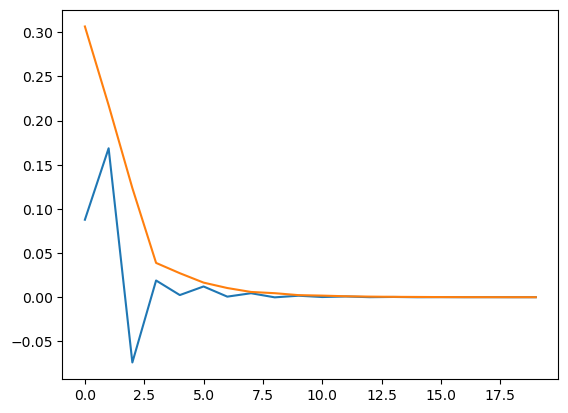

In [4]:
def show_activations(acts):
    act_mean = []
    act_std = []
    for act in acts:
        act = act.detach()
        act_mean.append(act.mean())
        act_std.append(act.std())

    plt.plot(act_mean)
    plt.plot(act_std)

show_activations(acts)

Essencialmente, a operação que uma rede neural faz é dada por:

In [5]:
# Batch de dados
x = torch.rand(10)
# Parâmetros das camadas
weight = 2.
bias = 2.
# 100 camadas
for i in range(100):
    x = (weight*x+bias)
print(x)

tensor([3.2545e+30, 3.4479e+30, 3.0232e+30, 3.5234e+30, 3.4449e+30, 3.3905e+30,
        2.7864e+30, 3.3439e+30, 3.0952e+30, 3.4286e+30])


Tente achar valores de `weight` e `bias` que não levem o valor de x acima a 0, infinito ou algum valor trivial.

### Batch Normalization

Ao normalizarmos os valores, as ativações se tornam bem comportadas!

In [6]:
def normalization(x):
    mean = x.mean()
    std = x.std()
    return (x-mean)/std

x = torch.rand(10)
weight = 20.
bias = -10.
for i in range(10):
    x = (weight*x+bias)
    x = normalization(x)
print(x)

tensor([-1.6341,  0.7075, -0.2681, -0.5265,  0.9641, -1.5134,  0.3172,  0.4574,
         0.1031,  1.3927])


Mas e se a escala dos valores for relevante para a classificação? Por exemplo, talvez um filtro tenda a gerar valores em torno de 10, enquanto que outro filtro gere valores em torno de 0.1. Essa informação será perdida após a normalização.

Uma camada batchnorm permite reescalar os valores caso seja necessário. Os parâmetros de escala são aprendidos durante o treinamento.

In [7]:
class BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Parameter define um tensor com requires_grad=True e que é registrado 
        # como parâmetro treinável do modelo
        self.gamma = nn.Parameter(torch.tensor(1.))
        self.beta = nn.Parameter(torch.tensor(0.))

        self.eps = 1e-5

    def forward(self, x):

        mean = x.mean()
        var = x.var()   # Variância
        # eps evita divisão por 0
        x_norm = (x-mean)/torch.sqrt(var+self.eps)

        # Reescala os valores
        y = self.gamma*x_norm + self.beta

        return y
    
bn = BatchNorm()
bn(100*torch.rand(10))


tensor([ 0.5646, -0.8173, -1.0018, -0.1314,  0.8818, -1.1710,  0.4094,  1.5579,
        -1.1965,  0.9041], grad_fn=<AddBackward0>)

Mas temos um problema. E quando formos aplicar a rede após o treinamento em uma única imagem? Cada camada terá apenas uma única ativação, o que pode ser um problema. Para evitar isso, durante o treinamento podemos armazenar a média e desvio padrão de todos os batches, e usar a estimativa desses parâmetros de todos os batches para normalizar os valores ao aplicar em uma única imagem.

### Desvendando a camada BatchNorm do Pytorch

In [8]:
# Batchnorm aplicado em 3 canais
bn = nn.BatchNorm1d(3)
print(bn.weight)
print(bn.bias)

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


A longo de vários batches, a camada estima a média e variância dos dados:

In [9]:
for i in range(100):
    # Batches de 4 elementos, 3 canais cada e 6 valores para cada canal
    # Os valores gerados possuem média 4 e variância 9.
    x = torch.normal(mean=4, std=1, size=(4,3,6))
    _ = bn(x)
    print('mean', bn.running_mean)
    #print('var', bn.running_var)



mean tensor([0.3934, 0.4001, 0.3852])
mean tensor([0.7499, 0.7366, 0.7439])
mean tensor([1.0791, 1.0591, 1.1035])
mean tensor([1.3765, 1.3668, 1.3893])
mean tensor([1.6449, 1.6403, 1.6564])
mean tensor([1.8916, 1.9052, 1.8672])
mean tensor([2.0885, 2.0970, 2.1018])
mean tensor([2.3134, 2.2999, 2.2783])
mean tensor([2.4771, 2.4696, 2.5050])
mean tensor([2.6355, 2.5656, 2.6647])
mean tensor([2.7875, 2.6763, 2.7601])
mean tensor([2.9807, 2.7801, 2.8936])
mean tensor([3.1106, 2.8772, 3.0373])
mean tensor([3.1863, 2.9689, 3.1271])
mean tensor([3.2860, 3.0518, 3.2010])
mean tensor([3.3216, 3.1603, 3.2814])
mean tensor([3.3990, 3.2579, 3.3287])
mean tensor([3.4362, 3.3299, 3.4137])
mean tensor([3.4915, 3.4127, 3.4988])
mean tensor([3.5506, 3.4659, 3.5558])
mean tensor([3.6067, 3.5149, 3.5962])
mean tensor([3.6448, 3.5464, 3.6516])
mean tensor([3.6750, 3.6072, 3.6874])
mean tensor([3.6831, 3.6371, 3.7405])
mean tensor([3.6933, 3.6582, 3.7549])
mean tensor([3.7297, 3.6561, 3.7973])
mean tensor(

No modo eval, a média estimada é usada quando a camada for aplicada em novos dados:

In [10]:
# Batch de tamanho 1000 com valores de média 10
# A média do resultado deve ser aproximadamente 10-bn.running_mean
x = torch.normal(mean=10, std=6, size=(1000,3,60))
bn.eval()
y = bn(x)
print(y.mean())

tensor(5.7178, grad_fn=<MeanBackward0>)


Retornando o batchnorm para o modo .train faz com que a camada volte a normalizar pela média e desvio do batch:

In [11]:
x = torch.normal(mean=10, std=6, size=(1000,3,60))
bn.train()
y = bn(x)
print(y.mean())

tensor(1.9752e-08, grad_fn=<MeanBackward0>)
